#**Loading Dependencies**

In [ ]:
!pip install tensorflow_hub
!pip install keras tf-models-official pydot graphviz
!pip install tensorflow_text

In [ ]:
import numpy as np
import pandas as pd
import scipy
import tensorflow_text as text
import tensorflow as tf
import os
import shutil
import tensorflow_hub as hub
import official.nlp.bert.tokenization as tokenization
import matplotlib.pyplot as plt

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    print(e)
    
print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

1 Physical GPUs, 1 Logical GPUs
Version:  2.4.1
Eager mode:  True
Hub version:  0.12.0
GPU is available


# **Reading Dataset**

In [ ]:
df = pd.read_csv("data.csv", engine='python')

In [ ]:
x = df["text"].values
y = df["label"].values

In [ ]:
x

array(['I grew up near Little Italy ( not NY ) and parents grew up in Brooklyn .',
       'Report : Nuclear weapon drivers sometimes got drunk - Yahoo !',
       'Besides who would even bother to help them ?', ...,
       'You are an retarded psychopath !!!', 'Your�should�fuck�off�now',
       'you should go now.'], dtype=object)

In [ ]:
x.shape, y.shape

((2396,), (2396,))

#**Label Encoding**

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
one = OneHotEncoder()
y = one.fit_transform(y[:,np.newaxis]).toarray()

In [ ]:
y

array([[0., 1.],
       [0., 1.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [0., 1.]])

In [ ]:
one.inverse_transform(y)

array([['noHate'],
       ['noHate'],
       ['hate'],
       ...,
       ['hate'],
       ['hate'],
       ['noHate']], dtype=object)

#**Balanced Dataset**

(array([1197.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        1199.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

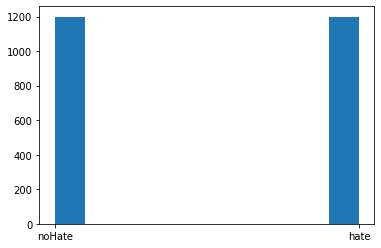

In [ ]:
plt.hist(one.inverse_transform(y))

In [ ]:
y

array([[0., 1.],
       [0., 1.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [0., 1.]])

#**Loading Bert Models**

In [ ]:
# pip install -q tf-models-official

In [ ]:
encoder_layer = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4', trainable = True)

#**Text Preproccesing**

# **Splitting Dataset**

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.1)

In [ ]:
preprocessor = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")

In [ ]:
num_class = len(one.categories_[0])
model = tf.keras.Sequential()
input = tf.keras.layers.Input(shape=(), dtype=tf.string)
encoder_input = preprocessor(input)
outputs = encoder_layer(encoder_input)
pooled_output = outputs["pooled_output"]
sequence_output = outputs["sequence_output"]
output = tf.keras.layers.Dropout(rate=0.1)(pooled_output)
output = tf.keras.layers.Dense(num_class, activation='softmax', name='output')(output)
 
model = tf.keras.Model(
    inputs=input,
        outputs=output)

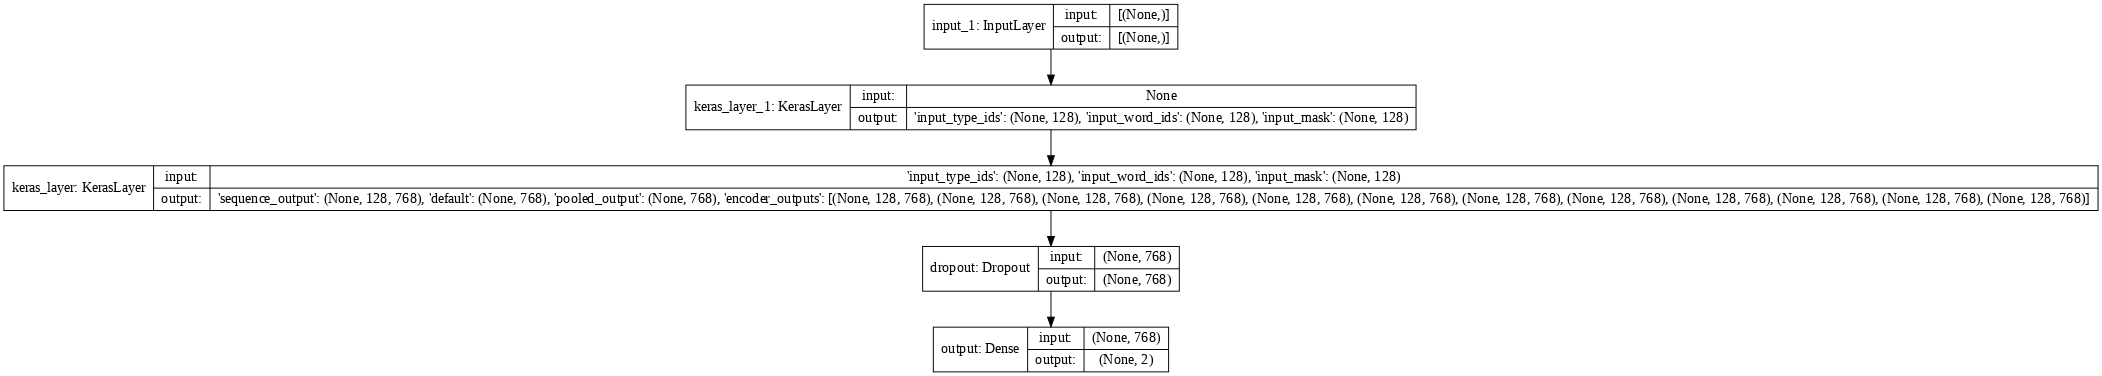

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=70)

In [ ]:
epochs = 3
batch_size = 8  # select based on your GPU resources
eval_batch_size = batch_size

optimizer = tf.keras.optimizers.Adam(learning_rate = 2e-5)

In [ ]:
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None,)]            0                                            
__________________________________________________________________________________________________
keras_layer_1 (KerasLayer)      {'input_type_ids': ( 0           input_1[0][0]                    
__________________________________________________________________________________________________
keras_layer (KerasLayer)        {'sequence_output':  109482241   keras_layer_1[0][0]              
                                                                 keras_layer_1[0][1]              
                                                                 keras_layer_1[0][2]              
______________________________________________________________________________________________

In [ ]:
history = model.fit(x_train,
                    y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(x_test, y_test),
                    verbose=1,
                    )

Epoch 1/3
270/270 [==============================] - 126s 467ms/step - loss: 0.0230 - accuracy: 0.9940 - val_loss: 0.6661 - val_accuracy: 0.8583
Epoch 2/3
270/270 [==============================] - 126s 467ms/step - loss: 0.0224 - accuracy: 0.9935 - val_loss: 0.7709 - val_accuracy: 0.8458
Epoch 3/3
270/270 [==============================] - 126s 467ms/step - loss: 0.0342 - accuracy: 0.9893 - val_loss: 0.5880 - val_accuracy: 0.8792


In [ ]:
model.save('/content/drive/MyDrive/finalModel')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/finalModel/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/finalModel/assets


In [ ]:
pretrained = tf.keras.models.load_model('/content/drive/MyDrive/finalModel')

In [ ]:
def label(prediction):
  if prediction == 0:
    return "Offensive"
  if prediction == 1:
    return "Normal"

In [ ]:
tweets = "you are psychopath"
#processed_tweet = bert_encode([tweets], tokenizer, 512)
prediction = np.argmax(pretrained.predict([tweets]),axis=1)
print(label(prediction))

Offensive


In [ ]:
tweets = "you are a good boy"
#processed_tweet = bert_encode([tweets], tokenizer, 512)
prediction = np.argmax(pretrained.predict([tweets]),axis=1)
print(label(prediction))

Normal


In [ ]:
!zip -r model.zip my_model/

  adding: my_model/ (stored 0%)
  adding: my_model/assets/ (stored 0%)
  adding: my_model/assets/vocab.txt (deflated 53%)
  adding: my_model/saved_model.pb (deflated 92%)
  adding: my_model/variables/ (stored 0%)
  adding: my_model/variables/variables.index (deflated 82%)
  adding: my_model/variables/variables.data-00000-of-00001 (deflated 18%)


In [ ]:
!cp model.zip /content/drive/MyDrive/

In [ ]:
model.evaluate(x_test, y_test)

8/8 [==============================] - 3s 291ms/step - loss: 0.0811 - accuracy: 0.9792


[0.08111841231584549, 0.9791666865348816]

In [ ]:
!ls -sh model.zip

1.1G model.zip
